Training: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]

Average reward: -0.06247195823277836
Time taken: 6.15 seconds


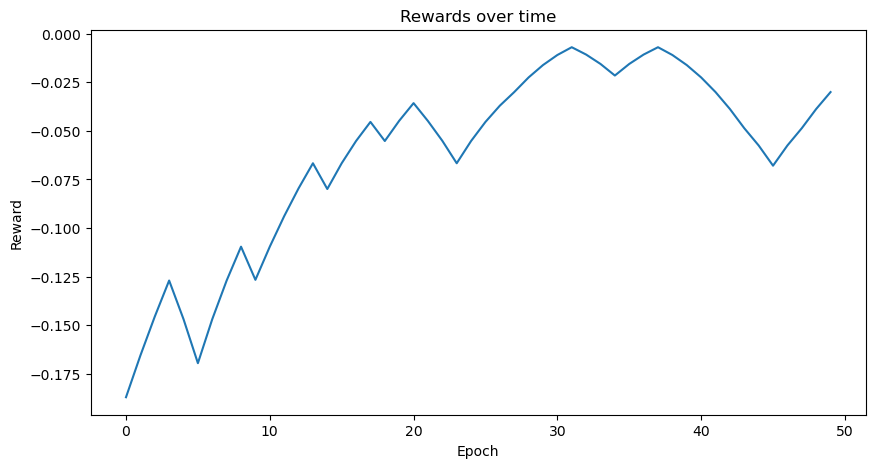

Optimal values:
Power: 263.55, Scan Speed: 2.98, Reward: -0.00002
Power: 285.47, Scan Speed: 3.00, Reward: -0.00004
Power: 275.47, Scan Speed: 3.00, Reward: -0.00004


In [91]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
import time

class DQNAgent:
    def __init__(self, state_size=2, action_size=4, gamma=0.5, epsilon=1, epsilon_min=0.01, epsilon_decay=0.9995, learning_rate=0.001, batch_size=32, model_name="model_0"):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.model_name = model_name
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = "cpu"
        self.model = self._build_model().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def _build_model(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(self.state_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.model(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = torch.nn.functional.mse_loss(current_q_values.squeeze(), target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, model_name="model_0.pth"):
        self.model.load_state_dict(torch.load(model_name, map_location=self.device))

    def save(self, model_name="model_0.pth"):
        torch.save(self.model.state_dict(), model_name)


    # numbers based on the paper
    @staticmethod
    def H_star(power, scan_speed, absorptivity=0.3, rho=2680.0, Cp=915.0, T_solid=817.0, T_0=300.0, hf=40000.0, Diffusivity=0.000097, beam_diameter=0.0001):
        H = (4 * absorptivity * power)/(np.pi*rho*(Cp*(T_solid - T_0) + hf) * np.sqrt(Diffusivity * scan_speed * beam_diameter**3))
        return H
    # reward function
    @staticmethod
    def reward(power, scan_speed):
        H = DQNAgent.H_star(power, scan_speed)
        return (-((H * 0.3*0.9*100)-120)**2 - 1000*((scan_speed - 3)**2))/36000
    
    def train(self, episodes=100):
        for e in tqdm(range(episodes), desc="Training"):
            state = np.random.rand(2)
            state[0] = state[0] * 350 + 50  # Scale power to 50-400 range
            state[1] = state[1] * 2.8 + 0.2  # Scale scan speed to 0.2-3 range
            rewards = []
            for time in range(50):
                # print(self.epsilon)
                action = self.act(state)
                
                # Apply the action
                next_state = state.copy()
                if action == 0:  # lower power
                    next_state[0] = max(50, next_state[0] - 10)
                elif action == 1:  # increase power
                    next_state[0] = min(400, next_state[0] + 10)
                elif action == 2:  # lower scan speed
                    next_state[1] = max(0.2, next_state[1] - 0.1)
                elif action == 3:  # increase scan speed
                    next_state[1] = min(3, next_state[1] + 0.1)
                
                reward = self.reward(next_state[0], next_state[1]) if next_state[0] >= 50 and next_state[1] >= 0.2 else -1
                rewards.append(reward)

                done = False
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.replay()
        print(f"Average reward: {np.mean(rewards)}")
        self.save()
        return rewards
    
    def plot_rewards(self, rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.title('Rewards over time')
        plt.xlabel('Epoch')
        plt.ylabel('Reward')
        plt.show()

    def optimal_values(self):
        # print the 3 most optimal values of power and scan speed
        optimal_values = []
        for state, action, reward, next_state, done in self.memory:
            optimal_values.append((state, reward))
        optimal_values = sorted(optimal_values, key=lambda x: x[1], reverse=True)
        return optimal_values[:3]

if __name__ == "__main__":
    start_time = time.time()
    name = "model_0"
    agent = DQNAgent(2, 4, model_name=name)
    rewards = agent.train(episodes=100)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    agent.plot_rewards(rewards)
    print("Optimal values:")
    for state, reward in agent.optimal_values():
        print(f"Power: {state[0]:.2f}, Scan Speed: {state[1]:.2f}, Reward: {reward:.5f}")